In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import geopy.geocoders
from geopy.geocoders import Nominatim
from sklearn.linear_model import LinearRegression
import numpy as np

%matplotlib inline
pd.set_option('display.max_colwidth', -1) #setting used to display the full links properly

## Read file and clean variables

In [2]:
#read csv
df = pd.read_csv('all_listings_9Apr20.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24158 entries, 0 to 24157
Data columns (total 13 columns):
address          24158 non-null object
amenities        18563 non-null object
area             24158 non-null object
bathrooms        22819 non-null float64
bedrooms         22819 non-null object
description      23517 non-null object
details          23576 non-null object
lease            24158 non-null object
link             24158 non-null object
name             24158 non-null object
price            24157 non-null object
property_type    22950 non-null object
psf_price        24158 non-null object
dtypes: float64(1), object(12)
memory usage: 2.4+ MB


In [3]:
df.head()

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,price,property_type,psf_price
0,12 Dairy Farm Lane - D23,"Function Room,Water Feature,High Ceiling,Gym,J...",624 sqft / 57.97 sqm,2.0,2,DAIRY FARM RESIDENCES – BRIEF\nOur development...,"Facing,North South,District,D23",2024 - 99 years,https://www.99.co/singapore/sale/property/dair...,Dairy Farm Residences,"$969,000",Condo,"$1,553 psf"
1,2 Shunfu Road - D20,"Jogging Track,Games Room,Gym,Sea View,Steam Ro...",764 sqft / 70.97 sqm,NaN,NaN,Jadescape (Former Shunfu Ville)\r\n\r\nJadesca...,"Furnishing,Unfurnished,Facing,North South,Avai...",2023 - 99 years,https://www.99.co/singapore/sale/property/jade...,JadeScape,"$1,275,408",Condo,"$1,669 psf"
2,21 Marina Way - D1,"Clubhouse,Gym,City View,Jacuzzi,Outdoor Dining...",710 sqft / 65.96 sqm,2.0,1,Prices dropped. Hurry! \nBrought to you by M+S...,"Facing,South West,Availability,Now,District,D01",2018 - 99 years,https://www.99.co/singapore/sale/property/mari...,Marina One Residences,"$1,580,000",Condo,"$2,225 psf"
3,3 Jalan Kemaman - D12,"Clubhouse,Pool Deck,Sky Lounge,Gym,Tennis Cour...",441 sqft / 40.97 sqm,1.0,1,VERTICUS – DISTRICT 12 – JALAN KEMAMAN\r\n\r\n...,"Furnishing,Unfurnished,Facing,North South,Avai...",- Freehold,https://www.99.co/singapore/sale/property/vert...,Verticus,"$889,000",Condo,"$2,016 psf"
4,5 Jalan Kemaman - D12,"Clubhouse,Bomb Shelter,Greenery View,Swimming ...",635 sqft / 58.99 sqm,1.0,2,VERTICUS – FREEHOLD at DISTRICT 12 – JALAN KEM...,"Furnishing,Unfurnished,Availability,Now,Distri...",1993 - Freehold,https://www.99.co/singapore/sale/property/kema...,Kemaman Point,"$1,244,000",NaN,"$1,959 psf"


In [4]:
# web scraping might have pulled duplicates if the same property is listed in multiple categories.
# drop duplicates. 
# if combining data pulled at different times, prices might have changed - in that case, drop duplicates based on link instead and only take the latest pulled data.
df = df.drop_duplicates(keep='first')
# df.loc[:,'listing_id'] = df['link'].apply(lambda x: x[x.rfind('-')+1:]) # this line extracts the listing id from the link. 

In [5]:
# price is in string format containing $ and ,.
# convert price to numeric
df.loc[:,'price'] = pd.to_numeric(df['price'].str.replace('$','').str.replace(',',''),errors='coerce')

# convert psf_price to numeric
df.loc[:,'psf_price'] = df['psf_price'].str.findall('([0-9]+)').str.join('').astype(int) 
# df.loc[:,'psf_price'] = df['psf_price'].str.replace('$','').str.replace(',','').str.replace(' psf','').astype(int)] #alternative method

# convert area to numeric in sqft
df['area'] = df['area'].map(lambda x: int(x.split(' / ')[0].replace(',','').replace(' sqft','')))

In [6]:
# bedrooms are not numeric for some reason.
df.bedrooms.unique()

array(['2', nan, '1', '3', '9', '4', '5', '6', '7', '8', '0', '10', ' '],
      dtype=object)

In [7]:
# it's because bedroom data has string containing whitespace ' '. 
df[df.bedrooms==' ']

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,price,property_type,psf_price
4255,Ernani Street - D15,NaN,1600,5.0,,TOP Q1 2020,"Availability,Now,Tenancy Current Rent,S$0,Cost...",1980 - Freehold,https://www.99.co/singapore/sale/property/erna...,Opera Estate,3800000.0,Terraced House,2375
4257,Watten Estate Road - D11,NaN,4600,5.0,,Come Immerse the Peaceful Vibes and Tranquilit...,"Availability,Now,Tenancy Current Rent,S$0,Cost...",- Freehold,https://www.99.co/singapore/sale/property/watt...,Watten Estate,8900000.0,Bungalow,1935
4258,Watten Close - D11,NaN,1800,2.0,,New Listing! Highly Sought after location! Don...,"Availability,Now,Tenancy Current Rent,S$0,Cost...",- Freehold,https://www.99.co/singapore/sale/property/watt...,Watten Estate,4500000.0,Terraced House,2500
4261,Jalan Dermawan - D23,NaN,8450,3.0,,Design your own house or Owner design for You!...,"Availability,Now,Tenancy Current Rent,S$0,Cost...",- Freehold,https://www.99.co/singapore/sale/property/jala...,Hillview Garden Estate,7400000.0,Semi-Detached House,876
4345,Jalan Lakum - D28,NaN,3800,7.0,,Swimming pool. Lift. Equipped with full solar ...,"Availability,Now,Tenancy Current Rent,S$0,Cost...",2013 - Freehold,https://www.99.co/singapore/sale/property/jala...,Seletar Hills Estate,5950000.0,Terraced House,1566
4346,Jalan Emas Urai - D23,"Jacuzzi,Lap Pool",3821,4.0,,Rare 3 storey Cluster House with Basement & Ro...,"Availability,Now,Tenancy Current Rent,S$0,Cost...",2009 - 999 years,https://www.99.co/singapore/sale/property/jala...,Chestnut Residences,2800000.0,Cluster House,733
4436,Jalan Lim Tai See - D10,"Swimming Pool,Security,Jacuzzi,Playground,Parking",0,5.0,,*******FREEHOLD STRATA LANDED D10 Cluster Hous...,"Availability,Now,Tenancy Current Rent,S$0,Cost...",2011 - Freehold,https://www.99.co/singapore/sale/property/jala...,Ventura Heights,3900000.0,Semi-Detached House,837
4437,Conway Grove - D19,NaN,6190,3.0,,*******Freehold Semi-D House in SERANGOON Gard...,"Availability,Now,Tenancy Current Rent,S$0,Cost...",2014 - 999 years,https://www.99.co/singapore/sale/property/conw...,Serangoon Garden Estate,8000000.0,Semi-Detached House,1292
4479,Jalan Langgar Bedok - D16,"Swimming Pool,Security,Wading Pool,Parking",3485,3.0,,Double storey Corner Terrace that sits atop th...,"Availability,Now,Tenancy Current Rent,S$0,Cost...",1986 - 999 years,https://www.99.co/singapore/sale/property/jala...,Lucky Hill,4500000.0,Corner Terrace,1291
8113,2 Whampoa East - D12,"Function Room,Water Feature,Gym,Jacuzzi,Tennis...",441,1.0,,1bedroom for Sale!\r\n\r\n\r\n- walking distan...,"Furnishing,Partially Furnished,District,D12",2016 - 99 years,https://www.99.co/singapore/sale/property/eigh...,Eight Riversuites,730000.0,Condo,1655


In [8]:
# these rows have number of bathroom data filled, which is a good proxy for the value of number of bedrooms
df.loc[df.bedrooms==' ','bedrooms'] = df[df.bedrooms==' ']['bathrooms']
df.loc[:,'bedrooms'] = pd.to_numeric(df['bedrooms'])

In [67]:
# some property_type is na. some of this information can be inferred from the link (99.co....<landed>.... or 99.co...<hdb>...)
df.loc[(df.property_type.isna())&(df.link.str.contains('landed')),'property_type'] = 'Landed'
df.loc[(df.property_type.isna())&(df.link.str.contains('hdb')),'property_type'] = 'HDB'
df.loc[(df.property_type.isna())&(df.link.str.contains('condo')),'property_type'] = 'Condo'

## EDA

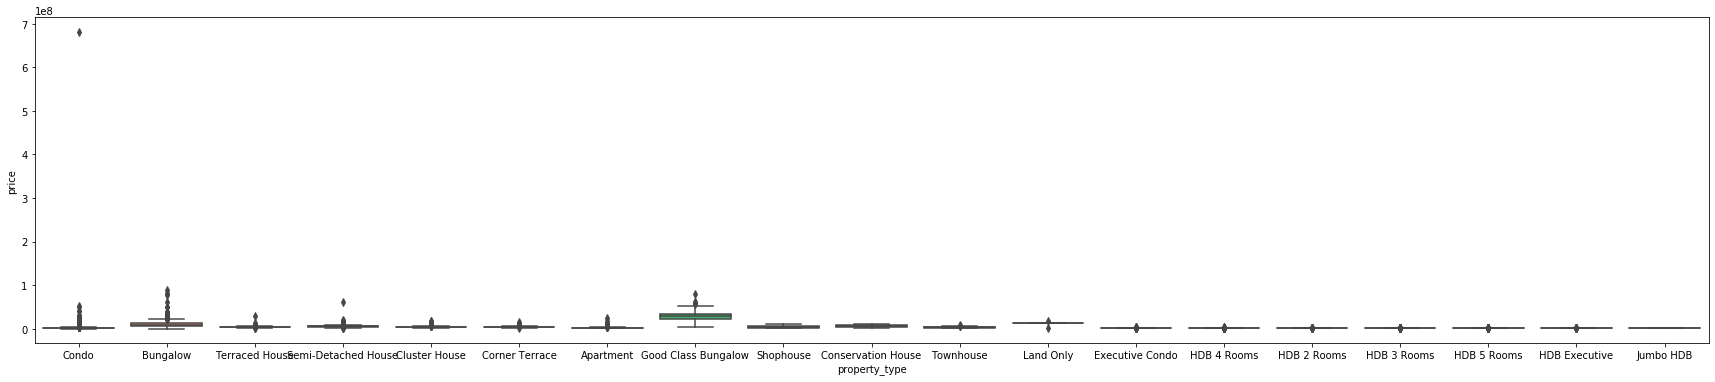

In [9]:
# EDA on price data
plt.figure(figsize=(30, 6))
sns.boxplot(data=df, x='property_type', y='price')

In [10]:
# there is an outlier at over $600mil
# remove outlier
df = df[df.price<5e8]

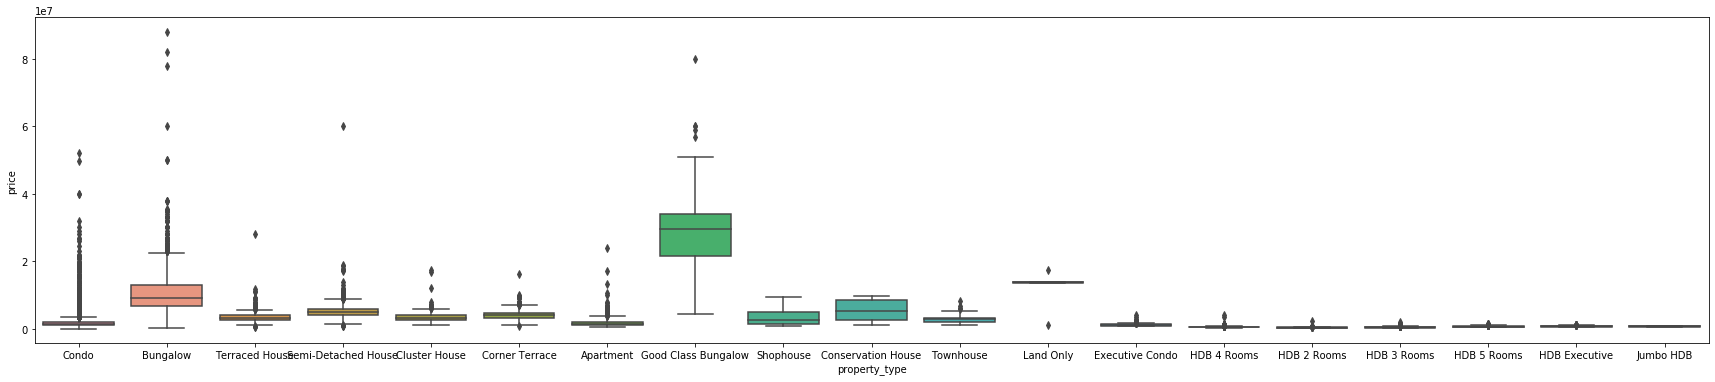

In [11]:
### EDA based on property type
# box plot
plt.figure(figsize=(30, 6))
sns.boxplot(data=df, x='property_type', y='price')

In [12]:
### EDA based on property type
# summary price stats
df.groupby('property_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Apartment,349.0,2.045329e+06,2.158176e+06,480000.0,1000000.0,1380000.0,2068000.0,24000000.0
Bungalow,1456.0,1.103977e+07,6.997294e+06,100000.0,6800000.0,9100000.0,13007015.0,88000000.0
Cluster House,522.0,3.261654e+06,1.386101e+06,1190000.0,2482500.0,3032000.0,3880000.0,17439488.0
Condo,7408.0,1.890141e+06,2.248818e+06,0.0,981450.0,1375225.0,1968000.0,52217000.0
Conservation House,22.0,5.576273e+06,3.127837e+06,949999.0,2680000.0,5175000.0,8500000.0,9800000.0
Corner Terrace,861.0,4.049343e+06,1.316525e+06,700000.0,3200000.0,3900000.0,4690000.0,16130000.0
Executive Condo,804.0,1.081893e+06,2.831442e+05,700000.0,899075.0,998000.0,1210000.0,3980000.0
Good Class Bungalow,127.0,2.911844e+07,1.167995e+07,4188000.0,21500000.0,29600000.0,33900000.0,80000000.0
HDB 2 Rooms,233.0,3.426155e+05,1.523236e+05,218000.0,268000.0,310000.0,368000.0,2150000.0


In [13]:
### baseline prediction of regression model
# using mean price by property type
# the baseline RMSE is calculated from the property price compared to the mean price of its property type - calculation is equivalent to std dev with ddof=0
def baseline_rmse(x):
    return x.std(ddof=0)
df.groupby('property_type')['price'].agg(['mean',baseline_rmse])

,mean,baseline_rmse
property_type,,
Apartment,2.045329e+06,2.155081e+06
Bungalow,1.103977e+07,6.994890e+06
Cluster House,3.261654e+06,1.384772e+06
Condo,1.890141e+06,2.248667e+06
Conservation House,5.576273e+06,3.055923e+06
Corner Terrace,4.049343e+06,1.315760e+06
Executive Condo,1.081893e+06,2.829680e+05
Good Class Bungalow,2.911844e+07,1.163388e+07
HDB 2 Rooms,3.426155e+05,1.519964e+05


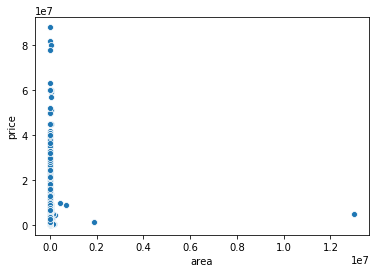

In [37]:
sns.scatterplot(data=df,x='area',y='price')

In [29]:
# there are outliers for area information, which have been wrongly entered by the property agent. 
df[df.area>10000]

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,price,property_type,psf_price
15,Jalan Jintan - D9,"Maid Room,Greenery View",17760,3.0,4.0,2 storey inter terrace at Mount Elizabeth vici...,"Condition,Land Only / For Rebuilding,Landed Ho...",- Freehold,https://www.99.co/singapore/sale/property/jala...,Kimsia Park,5280000.0,Terraced House,297
17,Holland Grove View - D10,"Stove,Renovated,Aircon,Balcony",35520,5.0,4.0,Central New List: \n\nD10 - Holland vicinity \...,"Facing,South,Landed House Area Zoning,2 Storey...",1997 - 99 years,https://www.99.co/singapore/sale/property/holl...,Holland Grove,6600000.0,Semi-Detached House,186
51,Garlick Avenue - D10,"Maid Room,Greenery View,Patio / PES,Ground Flo...",16170,9.0,6.0,Rare good class bungalow on elevated land\nMaj...,"Furnishing,Partially Furnished,Facing,South,Av...",-,https://www.99.co/singapore/sale/property/garl...,Garlick Avenue,28000000.0,Good Class Bungalow,1732
56,Oakwood Grove - D25,"Maid Room,Utility Room,Study Room,High Ceiling...",12312,8.0,9.0,"D25 Landed\n\nLand size 12,312 Sqft\nCurrent B...","Facing,East,Availability,Now,Landed House Area...",-,https://www.99.co/singapore/sale/property/oakw...,Oakwood Grove,6200000.0,Bungalow,504
84,Oakwood Grove - D25,"Maid Room,Greenery View,Patio / PES,Renovated,...",12321,8.0,9.0,"D25 Landed\n\nLand size 12,312 Sqft\nCurrent B...","Facing,East,Availability,Now,Landed House Area...",-,https://www.99.co/singapore/sale/property/oakw...,Oakwood Grove,5500008.0,Bungalow,446
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24033,Singapore 824176 - D19,"Greenery View,Balcony,Bomb Shelter,Renovated",12744,2.0,3.0,"Hi There! Are you looking for a Spacious, Brig...","Furnishing,Partially Furnished,Facing,North,Av...",2003 -,https://www.99.co/singapore/sale/property/176d...,176D Edgefield Plains,400000.0,HDB 5 Rooms,31
24040,Singapore 791469 - D28,NaN,10774,2.0,3.0,**New Exclusive listing v high floor unit**\r\...,"District,D28",- 99 years,https://www.99.co/singapore/sale/property/469a...,469A Sengkang West Way,498000.0,HDB 3 Rooms,46
24083,Singapore 824601 - D19,"Maid Room,Low Floor,Greenery View,Renovated,Bo...",10537,2.0,3.0,Hey there! Searching for HDB 4 Room flat that ...,"Furnishing,Partially Furnished,Facing,North,Av...",2012 - 99 years,https://www.99.co/singapore/sale/property/601d...,601D Punggol Central,430000.0,HDB 4 Rooms,41
24086,Singapore 560501 - D20,"Greenery View,Balcony",150845,3.0,3.0,"Mins Walk To Amk Hub & MRT, North South Facing...","Furnishing,Partially Furnished,Facing,North,Av...",1981 - 99 years,https://www.99.co/singapore/sale/property/501-...,501 Ang Mo Kio Avenue 5,510000.0,HDB 5 Rooms,3


In [115]:
# can be seen that many HDB listings have area of over 10,000 sqft which is not possible.
# from https://www.teoalida.com/singapore/hdbrecords/, the largest hdb is 215sqm.
# filter out hdb with area > 215sqm (2315sqft)
df = df[~(df.property_type.str.contains('HDB')&(df.area>2315))]

# biggest landed property in singapore is 52000sqft. filter out property with area >52,000sqft
df = df[df.area<52000]

In [117]:
### Extract the district information
# most district information is in the address column after the hyphen
df.loc[:,'district'] = df['address'].apply(lambda x: x.split(' - ')[1])

In [125]:
df.district.unique()

array(['D23', 'D20', 'D1', 'D12', 'D9', 'D15', 'D18', 'D19', 'D17', 'D3',
       'D10', 'D5', 'D13', 'D11', 'D28', 'D26', 'D7', 'D21', 'D14', 'D16',
       'D27', 'D8', 'D4', 'D25', 'D22', 'Floor #04', 'Floor #10',
       'Floor #01', 'Floor #09', 'Floor #00', 'D2', 'Floor #03',
       'Floor #07', 'Floor #02', 'Floor #3', 'Floor #Low ', 'Floor #Low',
       'Floor #05', 'Floor #27', 'Floor #High', 'Floor #28', 'Floor #11',
       'Floor #ground floor', 'Floor #15', 'Floor #12', 'Floor #08',
       'Floor #06', 'Floor #High Floor', 'Floor #high', 'Floor #low',
       'Floor #20', 'Floor #16', 'Floor #23', 'Floor #18', 'Floor #19',
       'Floor #17', 'Floor #14', 'Floor #13', 'Floor #30', 'Floor #34',
       'Floor #21', 'Floor #8', 'Floor #6', 'Floor #24', 'Floor #1',
       'Floor #Mid', 'Floor #22', 'Floor #44', 'Floor #Ground',
       'Floor #high /floor', 'Floor #31', 'Floor #41',
       'Floor #low, mid, high', 'Floor #18 ', 'D6', 'Floor #penthouse',
       'Floor ##05', 'Floor #

In [130]:
qwe = '#top'

    print('yay')

yay


In [131]:
import re

In [142]:
int(re.findall(r'#(\d+)','qwe#2')[0])

2

In [171]:
# seems like the info sometimes contains floor information. try to extract that info too.
# if there is a floor number, extract number. else, extract floor type.
# there are a few floor types: top/penthouse, high, mid, low, ground
def extract_floor_from_address(address):
    address = address.lower()
    if re.search(r'#(\d+)',address):
        return int(re.findall(r'#(\d+)',address)[0])
    elif ('penthouse' in address) or ('top' in address):
        return 'Top'

def extract_floor_type_from_address(address):
    address = address.lower()
    if ('penthouse' in address) or ('top' in address):
        return 'Top'
    elif ('mid' in address):
        return 'Mid'
    elif ('high' in address):
        return 'High'
    elif ('ground' in address):
        return 'Low'
    else:
        return np.nan

In [172]:
df = df.drop('floor_type',axis=1)

In [162]:
df

address  \
0      12 Dairy Farm Lane - D23           
1      2 Shunfu Road - D20                
2      21 Marina Way - D1                 
3      3 Jalan Kemaman - D12              
4      5 Jalan Kemaman - D12              
...                      ...              
24153  52 Choa Chu Kang North 6 - D23     
24154  700 Upper Changi Road East - D16   
24155  23 Marina Way - Floor #04          
24156  11 Dairy Farm Heights - D23        
24157  1 Keppel Bay View - D4             

                                                                                                                                                                                                                                                                                                                           amenities  \
0      Function Room,Water Feature,High Ceiling,Gym,Jet Pool,Yoga Corner,Tennis Court,Mid Floor,Undrewater Fitness Station,Outdoor Dining,Balcony,City View,Pool View,Renovated,Hammocks,Lap Pool,Greenery View,Pool Deck,Lounge,Wading Pool,Fountain,Playground,Fitness Corner,High Floor,Security,Fibre Ready,Reflexology Path,BBQ   
1      Jogging Track,Games Room,Gym,Sea View,Steam Room,Tennis Court,Pond,Karaoke,Balcony,Infinity Pool,Pavilion,Greenery View,Lounge,Swimming Pool,Waterfall,Playground,Fibre Ready,Reflexology Path                                                                                                                                  
2      Clubhouse,Gym,City View,Jacuzzi,Outdoor Dining,Balcony,Multi-purpose Hall,Bomb Shelter,Pavilion,Greenery View,Pool Deck,Lounge,Mini Golf Range,Wading Pool,Hydrotherapy Pool,Fitness Corner,High Floor,Fibre Ready,Lap Pool,BBQ                                                                                                 
3      Clubhouse,Pool Deck,Sky Lounge,Gym,Tennis Court,Parking,Undrewater Fitness Station,Outdoor Dining,Sky Terrace,Balcony,Bomb Shelter,Pavilion,Greenery View,Open Terrace,Swimming Pool,Spa Pool,Playground,Fitness Corner,High Floor,Security,Fibre Ready,Lap Pool,BBQ                                                            
4      Clubhouse,Bomb Shelter,Greenery View,Swimming Pool,Wading Pool,Squash Court,Parking,High Floor,Security,Fibre Ready,Gym,Balcony                                                                                                                                                                                                 
...                                                                                                                                ...                                                                                                                                                                                                 
24153  Clubhouse,Gym,Sauna,Swimming Pool,Wading Pool,Playground,Parking,Security,BBQ,Tennis Court                                                                                                                                                                                                                                      
24154  Clubhouse,Gym,Sauna,Tennis Court,Badminton Court,Parking,Balcony,Greenery View,Wading Pool,Swimming Pool,Utility Room,Playground,Fitness Corner,High Floor,Security,BBQ                                                                                                                                                         
24155  Clubhouse,Gym,Sea View,Outdoor Dining,Balcony,Multi-purpose Hall,Pavilion,Hydrotherapy Pool,Pool Deck,Wading Pool,Lounge,Mini Golf Range,Utility Room,Jacuzzi,Fitness Corner,Lap Pool,BBQ                                                                                                                                       
24156  Jogging Track,Function Room,Loft,High Ceiling,Rooftop Pool,Jet Pool,Spa Pavilion,Sauna,Steam Room,Tennis Court,Outdoor Dining,Patio / PES,Sky Terrace,Balcony,Ground Floor,Yoga Corner,Renovated,Greenery View,Wading Pool,Lounge,Ut

In [173]:
df.loc[:,'floor_type'] = df['district'].apply(extract_floor_type_from_address)

In [175]:
df[df['floor_type'].isna()]

address  \
0      12 Dairy Farm Lane - D23           
1      2 Shunfu Road - D20                
2      21 Marina Way - D1                 
3      3 Jalan Kemaman - D12              
4      5 Jalan Kemaman - D12              
...                      ...              
24153  52 Choa Chu Kang North 6 - D23     
24154  700 Upper Changi Road East - D16   
24155  23 Marina Way - Floor #04          
24156  11 Dairy Farm Heights - D23        
24157  1 Keppel Bay View - D4             

                                                                                                                                                                                                                                                                                                                           amenities  \
0      Function Room,Water Feature,High Ceiling,Gym,Jet Pool,Yoga Corner,Tennis Court,Mid Floor,Undrewater Fitness Station,Outdoor Dining,Balcony,City View,Pool View,Renovated,Hammocks,Lap Pool,Greenery View,Pool Deck,Lounge,Wading Pool,Fountain,Playground,Fitness Corner,High Floor,Security,Fibre Ready,Reflexology Path,BBQ   
1      Jogging Track,Games Room,Gym,Sea View,Steam Room,Tennis Court,Pond,Karaoke,Balcony,Infinity Pool,Pavilion,Greenery View,Lounge,Swimming Pool,Waterfall,Playground,Fibre Ready,Reflexology Path                                                                                                                                  
2      Clubhouse,Gym,City View,Jacuzzi,Outdoor Dining,Balcony,Multi-purpose Hall,Bomb Shelter,Pavilion,Greenery View,Pool Deck,Lounge,Mini Golf Range,Wading Pool,Hydrotherapy Pool,Fitness Corner,High Floor,Fibre Ready,Lap Pool,BBQ                                                                                                 
3      Clubhouse,Pool Deck,Sky Lounge,Gym,Tennis Court,Parking,Undrewater Fitness Station,Outdoor Dining,Sky Terrace,Balcony,Bomb Shelter,Pavilion,Greenery View,Open Terrace,Swimming Pool,Spa Pool,Playground,Fitness Corner,High Floor,Security,Fibre Ready,Lap Pool,BBQ                                                            
4      Clubhouse,Bomb Shelter,Greenery View,Swimming Pool,Wading Pool,Squash Court,Parking,High Floor,Security,Fibre Ready,Gym,Balcony                                                                                                                                                                                                 
...                                                                                                                                ...                                                                                                                                                                                                 
24153  Clubhouse,Gym,Sauna,Swimming Pool,Wading Pool,Playground,Parking,Security,BBQ,Tennis Court                                                                                                                                                                                                                                      
24154  Clubhouse,Gym,Sauna,Tennis Court,Badminton Court,Parking,Balcony,Greenery View,Wading Pool,Swimming Pool,Utility Room,Playground,Fitness Corner,High Floor,Security,BBQ                                                                                                                                                         
24155  Clubhouse,Gym,Sea View,Outdoor Dining,Balcony,Multi-purpose Hall,Pavilion,Hydrotherapy Pool,Pool Deck,Wading Pool,Lounge,Mini Golf Range,Utility Room,Jacuzzi,Fitness Corner,Lap Pool,BBQ                                                                                                                                       
24156  Jogging Track,Function Room,Loft,High Ceiling,Rooftop Pool,Jet Pool,Spa Pavilion,Sauna,Steam Room,Tennis Court,Outdoor Dining,Patio / PES,Sky Terrace,Balcony,Ground Floor,Yoga Corner,Renovated,Greenery View,Wading Pool,Lounge,Ut

In [178]:
hdb_df = df[df['link'].str.contains('hdb')].copy()
condo_df = df[df['link'].str.contains('condo')].copy()
landed_df = df[df['link'].str.contains('landed')].copy()

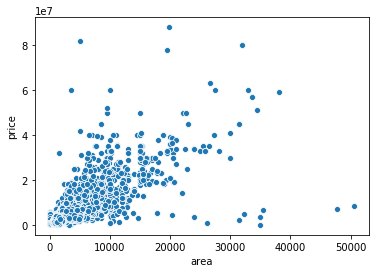

In [96]:
sns.scatterplot(data=df,x='area',y='price')

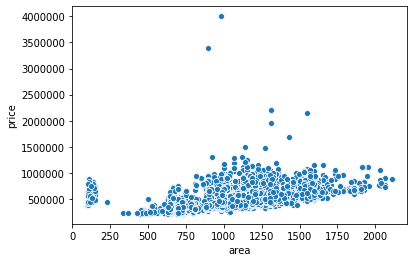

In [93]:
sns.scatterplot(data=hdb_df,x='area',y='price')

In [101]:
hdb_df[hdb_df.price>2e6]

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,price,property_type,psf_price
17270,Singapore 650419 - D23,"High Floor,Stove,Bomb Shelter,Renovated,Aircon",893,2.0,3.0,"Exclusive 4S unit high floor for sale. \nNo odd shape \n\nWindy & bright unit. \nLarge size with only one neighbour beside u\nMaster bedroom with attached toilet \n\nEnjoy amenities such as shops, supermarkets and coffeeshop right at your doorstep. \nWide array of buses to get u to anywhere. Alternatively 12 mins walk to Bukit Gombak MRT. \n\nFor viewing pls call/text Irene @ 9631 7367 for appt","Availability,Now,District,D23",1986 -,https://www.99.co/singapore/sale/property/419-bukit-batok-west-avenue-2-hdb-JNhjFvHXLhqtETyMsrjSJG,419 Bukit Batok West Avenue 2,3400006.0,HDB 4 Rooms,3807
17805,Singapore 380016 - D14,NaN,1313,4.0,4.0,"PROFIT! PROFIT! PROFIT!\r\n\r\nGet 4% yield immediately. \r\nRenovated shophouse, residential above, commercial below. Lovely abode next to kallang river. Next Best riverside investment. \r\n\r\nCome view and have the foresight to see the potential as I walk you through the place. \r\n\r\n","Availability,Now,District,D14",1975 - 99 years,https://www.99.co/singapore/sale/property/16-upper-boon-keng-road-hdb-S4Q2Kfg8VzhmDoDvs6fX67,16 Upper Boon Keng Road,2200000.0,HDB,1676
17925,Singapore 380016 - D14,NaN,1313,4.0,4.0,"PROFIT! PROFIT! PROFIT!\r\n\r\nGet 4% yield immediately. \r\nRenovated shophouse, residential above, commercial below. Lovely abode next to kallang river. Next Best riverside investment. \r\n\r\nCome view and have the foresight to see the potential as I walk you through the place. \r\n\r\n","Availability,Now,District,D14",1975 - 99 years,https://www.99.co/singapore/sale/property/16-upper-boon-keng-road-hdb-6FEbR2LxYNZSF7g8SbzGpP,16 Upper Boon Keng Road,2200000.0,HDB,1676
18145,Singapore 380016 - D14,NaN,1313,4.0,4.0,"PROFIT! PROFIT! PROFIT!\r\n\r\nGet 4% yield immediately. \r\nRenovated shophouse, residential above, commercial below. Lovely abode next to kallang river. Next Best riverside investment. \r\n\r\nCome view and have the foresight to see the potential as I walk you through the place. \r\n\r\n","Availability,Now,District,D14",1975 - 99 years,https://www.99.co/singapore/sale/property/16-upper-boon-keng-road-hdb-iHn6Ah9SRKpPZSMR2RPKST,16 Upper Boon Keng Road,2200000.0,HDB,1676
18354,Singapore 380016 - D14,NaN,1313,4.0,4.0,"PROFIT! PROFIT! PROFIT!\r\n\r\nGet 4% yield immediately. \r\nRenovated shophouse, residential above, commercial below. Lovely abode next to kallang river. Next Best riverside investment. \r\n\r\nCome view and have the foresight to see the potential as I walk you through the place. \r\n\r\n","Availability,Now,District,D14",1975 - 99 years,https://www.99.co/singapore/sale/property/16-upper-boon-keng-road-hdb-3QJ8wUCkhVdjJQrn6B3sda,16 Upper Boon Keng Road,2200000.0,HDB,1676
19160,Singapore 820133 - D19,"High Floor,Renovated",980,2.0,3.0,"133 Edgedale Fields - 4 Room Flat for Sale\n\nHigh floor\nWindy\nUnblock \nMinutes Walk to Coral Edge LRT and 3 Stops to Punggol MRT\nNear to Punggol 21, Punggol Plaza and lots of amenities \nViewing by appointment \n\nPlease call Simmone 9146 2435 for viewing appointment","Facing,North South,Availability,Now,District,D19",2003 -,https://www.99.co/singapore/sale/property/133-edgedale-plains-hdb-69gk4Y4rN2Fm6xjUBY8EGV,133 Edgedale Plains,4000000.0,HDB 4 Rooms,4082
22366,Singapore 520268 - D18,NaN,1550,3.0,2.0,TAMPINES STREET 21,"District,D18",1984 -,https://www.99.co/singapore/sale/property/268-tampines-street-21-hdb-qD6qb9wRqaoHX7DwjKxrKo,268 Tampines Street 21,2150000.0,HDB 2 Rooms,1387
22937,Singapore 380016 - D14,NaN,1313,4.0,4.0,"PROFIT! PROFIT! PROFIT!\r\n\r\nGet 4% yield immediately. \r\nRenovated shophouse, residential above, commercial below. Lovely abode next to kallang river. Next Best riverside investment. \r\n\r\nCome view and have the foresight to see the potential as I walk you through the place. \r\n\r\n","Availability

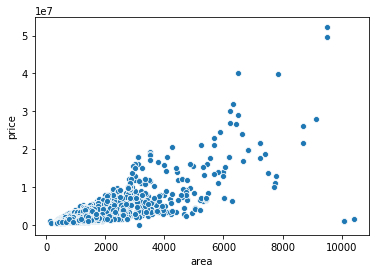

In [98]:
sns.scatterplot(data=condo_df,x='area',y='price')

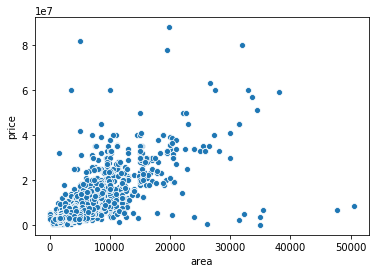

In [99]:
sns.scatterplot(data=landed_df,x='area',y='price')

## Feature Engineering

In [36]:
df.head()

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,price,property_type,psf_price
0,12 Dairy Farm Lane - D23,"Function Room,Water Feature,High Ceiling,Gym,J...",624,2.0,2.0,DAIRY FARM RESIDENCES – BRIEF\nOur development...,"Facing,North South,District,D23",2024 - 99 years,https://www.99.co/singapore/sale/property/dair...,Dairy Farm Residences,969000.0,Condo,1553
1,2 Shunfu Road - D20,"Jogging Track,Games Room,Gym,Sea View,Steam Ro...",764,NaN,NaN,Jadescape (Former Shunfu Ville)\r\n\r\nJadesca...,"Furnishing,Unfurnished,Facing,North South,Avai...",2023 - 99 years,https://www.99.co/singapore/sale/property/jade...,JadeScape,1275408.0,Condo,1669
2,21 Marina Way - D1,"Clubhouse,Gym,City View,Jacuzzi,Outdoor Dining...",710,2.0,1.0,Prices dropped. Hurry! \nBrought to you by M+S...,"Facing,South West,Availability,Now,District,D01",2018 - 99 years,https://www.99.co/singapore/sale/property/mari...,Marina One Residences,1580000.0,Condo,2225
3,3 Jalan Kemaman - D12,"Clubhouse,Pool Deck,Sky Lounge,Gym,Tennis Cour...",441,1.0,1.0,VERTICUS – DISTRICT 12 – JALAN KEMAMAN\r\n\r\n...,"Furnishing,Unfurnished,Facing,North South,Avai...",- Freehold,https://www.99.co/singapore/sale/property/vert...,Verticus,889000.0,Condo,2016
4,5 Jalan Kemaman - D12,"Clubhouse,Bomb Shelter,Greenery View,Swimming ...",635,1.0,2.0,VERTICUS – FREEHOLD at DISTRICT 12 – JALAN KEM...,"Furnishing,Unfurnished,Availability,Now,Distri...",1993 - Freehold,https://www.99.co/singapore/sale/property/kema...,Kemaman Point,1244000.0,NaN,1959


In [86]:
hdb5rm_df = df[df.property_type=='HDB 5 Rooms']

In [88]:
hdb5rm_df['price'].mean()

609020.0426296866

In [97]:
import numpy as np
np.sqrt(hdb5rm_df['price'].apply(lambda x: (x-609020.0426296866)**2).mean())

162158.2628961796

In [48]:
df[df['property_type'].notnull()][df[df['property_type'].notnull()]['property_type'].str.contains('HDB')]

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,price,property_type,psf_price,listing_id
16129,Singapore 543265 - D19,NaN,990 sqft / 91.97 sqm,2.0,3,Click link to view 360 House Video = http://bi...,"Furnishing,Partially Furnished,Availability,No...",2008 - 99 years,https://www.99.co/singapore/sale/property/265c...,265C Compassvale Link,"$570,000",HDB 4 Rooms,$576 psf,zScvBaMQDhzaQF7Y8bsMCh
16130,Singapore 160032 - D3,NaN,548 sqft / 50.91 sqm,1.0,2,Rare 2 Room Flat at Tiong Bahru MRT for Sale!!...,"Furnishing,Partially Furnished,Availability,No...",1971 -,https://www.99.co/singapore/sale/property/32-j...,32 Jalan Bukit Ho Swee,"$260,000",HDB 2 Rooms,$474 psf,mkJmVrRVTDnoMXiNDAoEAA
16131,Singapore 120306 - D5,"Greenery View,Renovated",721 sqft / 66.98 sqm,2.0,2,***New listing***\n\nHdb 3NG for sale\n\n* mid...,"Furnishing,Partially Furnished,Availability,No...",1979 - 99 years,https://www.99.co/singapore/sale/property/306-...,306 Clementi Avenue 4,"$299,000",HDB 3 Rooms,$415 psf,jAQxqtkSETKQWnbCMQnJQ4
16137,Singapore 821126 - D19,Bomb Shelter,"1,184 sqft / 109.99 sqm",3.0,2,Super Super Attractive Price!\nONLY $400K!\n5 ...,"Furnishing,Partially Furnished,Facing,South Ea...",2003 -,https://www.99.co/singapore/sale/property/126a...,126A Edgedale Plains,"$400,000",HDB 5 Rooms,$338 psf,aj5frZ7a5MnZBnFYmjCtj9
16138,Singapore 460406 - D16,"High Floor,City View,Sea View,Greenery View","1,270 sqft / 117.98 sqm",2.0,3,5RM/ 5I HDB @ Bedok North - For Sale\r\n======...,"Furnishing,Unfurnished,Facing,South,Availabili...",1980 - 99 years,https://www.99.co/singapore/sale/property/406-...,406 Bedok North Avenue 3,"$690,000",HDB 5 Rooms,$543 psf,aAtBqBCo4sog2WorA8i57U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24120,Singapore 530370 - D19,NaN,"1,087 sqft / 100.98 sqm",2.0,3,* Another Unit Brought to You by Evangeline * ...,"Availability,Now,District,D19",1999 -,https://www.99.co/singapore/sale/property/370-...,370 Hougang Street 31,"$458,000",HDB 4 Rooms,$421 psf,CjF49gZw7g7KX2YFufDtxB
24142,Singapore 123311 - D5,"Parking,Playground,Fitness Corner,Hydrotherapy...",861 sqft / 79.98 sqm,2.0,3,311C Clementi Avenue 4,"District,D05",2015 - 99 years,https://www.99.co/singapore/sale/property/311c...,311C Clementi Avenue 4,"$799,888",HDB 3 Rooms,$929 psf,33N7KxaHq2cpFkoK7hitjk
24143,Singapore 643654 - D22,NaN,"1,194 sqft / 110.92 sqm",2.0,3,654C JURONG WEST STREET 61\n------------------...,"Furnishing,Partially Furnished,District,D22",2002 -,https://www.99.co/singapore/sale/property/654c...,654C Jurong West Street 61,"$460,000",HDB 5 Rooms,$385 psf,9kPT6Hf3tuxkWyLf74ZSSD
24144,Singapore 794430 - D28,"High Floor,Corner Unit,Aircon","1,205 sqft / 111.94 sqm",2.0,3,Just MOP HDB 5 Room for Sale ....\n\nVery high...,"Furnishing,Partially Furnished,Availability,No...",2015 - 99 years,https://www.99.co/singapore/sale/property/430d...,430D Fernvale Link,"$600,000",HDB 5 Rooms,$498 psf,hHbWMBvJc9QwyYtQhz7YDL


In [38]:
df['bedrooms'].value_counts(dropna=False)

3      8468
2      3701
5      3568
4      3394
1      1618
NaN    1339
6      1252
7       429
8       157
10       84
0        75
9        58
         15
Name: bedrooms, dtype: int64

In [39]:
df['bathrooms'].value_counts(dropna=False)

2.0     10448
3.0      3025
1.0      2604
5.0      2178
4.0      2006
6.0      1501
NaN      1339
7.0       642
8.0       281
9.0       127
10.0        7
Name: bathrooms, dtype: int64

In [25]:
df['bedrooms'].unique()

array(['2', nan, '1', '3', '9', '4', '5', '6', '7', '8', '0', '10', ' '],
      dtype=object)

In [19]:
#instantiate geocoder
geolocator = Nominatim(user_agent='my_app/1')

In [20]:
address, (latitude, longitude)  = geolocator.geocode('Kemaman Point',country_codes='SG')

In [22]:
address

'Kemaman Point, Balestier, Singapore, Central, 329325, Singapore'

In [21]:
latitude, longitude

(1.3264101, 103.85069728522598)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24158 entries, 0 to 24157
Data columns (total 14 columns):
address          24158 non-null object
amenities        18563 non-null object
area             24158 non-null object
bathrooms        22819 non-null float64
bedrooms         22819 non-null object
description      23517 non-null object
details          23576 non-null object
lease            24158 non-null object
link             24158 non-null object
name             24158 non-null object
price            24157 non-null object
property_type    22950 non-null object
psf_price        24158 non-null object
price_numeric    24125 non-null float64
dtypes: float64(2), object(12)
memory usage: 2.6+ MB


In [13]:
df[df.property_type.isna()].link.values

array(['https://www.99.co/singapore/sale/property/kemaman-point-condo-JGZ5DFVeJPVDh2fTxDVucA',
       'https://www.99.co/singapore/sale/property/phillips-avenue-landed-89F43XxurnsYFwW6bQf2aN',
       'https://www.99.co/singapore/sale/property/sunset-square-landed-d7jqE4fUGCoXEMfDkx4Q4Y',
       ...,
       'https://www.99.co/singapore/sale/property/986b-buangkok-crescent-hdb-FGrrUtSe3ReXKF9ggWhEiL',
       'https://www.99.co/singapore/sale/property/986b-buangkok-crescent-hdb-nfz2ppjkHkcBA2Epb5XQGo',
       'https://www.99.co/singapore/sale/property/311b-clementi-avenue-4-hdb-ybReaQ6V7GdemBRoxiQojZ'],
      dtype=object)

In [ ]:
df['price_numeric'].plot(kind='box')

In [52]:
df = df[df['price2']<2e8]

In [32]:
df.shape

(24158, 14)

In [31]:
df['listing_id'].drop_duplicates(keep='first')

0        CB4Rz6Sdfb4FvgoKYrBnhJ
1        yhBy3rdA3sJag26VNCoWHh
2         epsbRyicZT9cQT8vTAToF
3        NoPhGyiiym5Uqwn35txcKU
4        JGZ5DFVeJPVDh2fTxDVucA
                  ...          
24153    zgtNtnegpKa38VbrTVYNZX
24154    wmzDaj5yX2doroDyUMdYGm
24155    AtBW8Ksynsxwdqv5ZpJDtF
24156    PEFRAwXfQpKnwB6ao7UvHM
24157    fdbc2gVBD7yyEw7FLvcgWX
Name: listing_id, Length: 24092, dtype: object

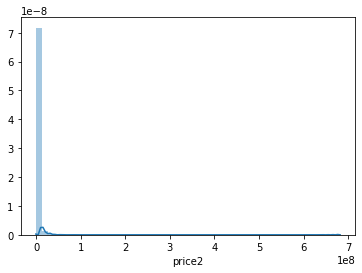

In [50]:
sns.distplot(df[df['price2'].notnull()]['price2'],hist=True)

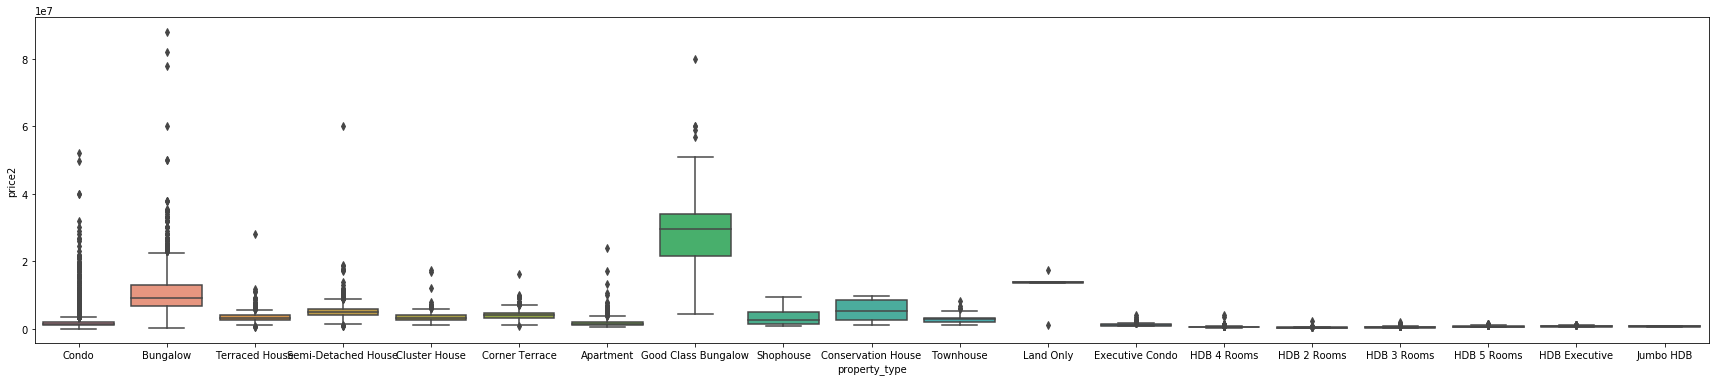

In [58]:
plt.figure(figsize=(30, 6))
sns.boxplot(y=df['price2'], x=df['property_type'])

C:\Users\justin.wong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


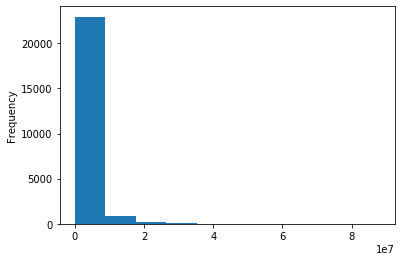

In [29]:
df[~(df['price2']>(2e8))]['price2'].plot('hist',color=)

C:\Users\justin.wong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='box')` instead of `Series.plot('box',)`.
  """Entry point for launching an IPython kernel.


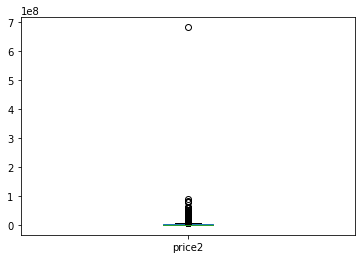

In [20]:
df['price2'].plot('box')

In [16]:
df[df['price2'].isna()]

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,price,property_type,psf_price,price2
8105,13 Canberra Walk - D27,"Penthouse,Fun Pool,Function Room,Gym,Hydrother...","1,001 sqft / 92.99 sqm",2.0,3,☀ *_Parc Canberra EC_* ☀\n\n📧 Flash this VVIP ...,"Facing,North South,Availability,Now,District,D27",2023 - 99 years,https://www.99.co/singapore/sale/property/parc...,Parc Canberra,To be confirmed,Condo,$0 psf,NaN
8107,4 Makeway Avenue - D9,"Gym,Sea View,Steam Room,Tennis Court,Balcony,P...",689 sqft / 64.01 sqm,2.0,2,Call 96209209 to enquire!,"Furnishing,Unfurnished,Facing,North South,Avai...",- 99 years,https://www.99.co/singapore/sale/property/kopa...,Kopar At Newton,To be confirmed,Condo,$0 psf,NaN
8108,13 Canberra Walk - D27,"Jogging Track,Fun Pool,Function Room,Gym,Steam...",818 sqft / 75.99 sqm,NaN,NaN,"300m, 5mins walk to Canberra MRT","District,D27",2023 - 99 years,https://www.99.co/singapore/sale/property/parc...,Parc Canberra,To be confirmed,Condo,$0 psf,NaN
8109,4 Makeway Avenue - D9,"Gym,Sea View,Steam Room,Tennis Court,Balcony,P...","1,819 sqft / 168.99 sqm",5.0,5,Call 96209209 to enquire!,"Furnishing,Unfurnished,Facing,North South,Avai...",- 99 years,https://www.99.co/singapore/sale/property/kopa...,Kopar At Newton,To be confirmed,Condo,$0 psf,NaN
8110,4 Makeway Avenue - D9,"Gym,Sea View,Steam Room,Tennis Court,Balcony,P...",614 sqft / 57.04 sqm,1.0,2,Call 96209209 to enquire!,"Furnishing,Unfurnished,Facing,North South,Avai...",- 99 years,https://www.99.co/singapore/sale/property/kopa...,Kopar At Newton,To be confirmed,Condo,$0 psf,NaN
8111,4 Makeway Avenue - D9,"Gym,Sea View,Steam Room,Tennis Court,Balcony,P...",517 sqft / 48.03 sqm,1.0,1,Call 96209209 to enquire!,"Furnishing,Unfurnished,Facing,North South,Avai...",- 99 years,https://www.99.co/singapore/sale/property/kopa...,Kopar At Newton,To be confirmed,Condo,$0 psf,NaN
8125,4 Makeway Avenue - D9,"Gym,Sea View,Steam Room,Tennis Court,Balcony,P...","3,251 sqft / 302.02 sqm",5.0,6,Call 96209209 to enquire!,"Furnishing,Unfurnished,Facing,North South,Avai...",- 99 years,https://www.99.co/singapore/sale/property/kopa...,Kopar At Newton,To be confirmed,Condo,$0 psf,NaN
8675,11 Balmoral Road - D10,"City View,Pavilion,Loft,Swimming Pool,High Cei...",603 sqft / 56.02 sqm,1.0,1,*The Hyde* \n\nA District 10 Freehold developm...,"Facing,North East,Availability,01 Oct 2022,Dis...",2022 - Freehold,https://www.99.co/singapore/sale/property/the-...,The Hyde,To be confirmed,Condo,$0 psf,NaN
8678,328 Changi Road - D14,"Retail Shops,Greenery View,Pool Deck,Jacuzzi,S...","1,184 sqft / 109.99 sqm",2.0,4,Call 98351348 to enquire!,"Furnishing,Unfurnished,Facing,North South,Avai...",- Freehold,https://www.99.co/singapore/sale/property/tedg...,Tedge,To be confirmed,Condo,$0 psf,NaN
9558,70 Truro Road - D8,Playground,807 sqft / 74.97 sqm,2.0,3,Just T.O.P.\nDirect Developer Sale\n+ Freehold...,"District,D08",2018 - Freehold,https://www.99.co/singapore/sale/property/70tr...,"$1,450,000",NaN,Condo,"$1,797 psf",NaN


y = price

x = 
bedrooms
bathrooms
area
district
floor
distance from mrt
distance from lrt

In [179]:
hdb_df

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,price,property_type,psf_price,district,floor_type
1256,Lilac Park - D28,Playground,2200,3.0,4.0,Lilac Park,NaN,1990 - Freehold,https://www.99.co/singapore/sale/property/property-in-singapore-landed-JkieMG5XD4hdbbCKHRZWb5,Lilac Park,3000000.0,Terraced House,1364,D28,NaN
8760,1 Keppel Bay View - D4,"Clubhouse,Bomb Shelter,Greenery View,Ground Floor,Swimming Pool,Jacuzzi,Playground,Patio / PES,Gym,BBQ,Tennis Court",1690,3.0,3.0,2 YEARS DEFERRED PAYMENT SCHEME IS BACK! ONLY FOR SELECTED VACANT UNITS!\r\n\r\nNEW STAR BUYS RELEASED! $180k ADDITIONAL DISCOUNT FROM PREVIOUS PRICE!\r\n\r\nReflections at Keppel Bay Relaunch\r\n\r\nSingapore's Most Iconic Waterfront Development\r\n\r\nMost Anticipated Blk 8 Villa is finally launching for sales!!! Don't Miss!\r\n\r\nBe the first to view these newly released premium villa units!\r\n\r\nNormal Payment Scheme with attractive Furniture Rebate!\r\n\r\nPriced to sell!\r\n\r\nAttractive price from $14XXpsf (cheaper than suburban prices)\r\n\r\nUnits with scenic views are available!\r\n\r\nCall Alfred @ 96428496 for exclusive viewing and more information now!\r\n\r\nAlfred Chee \r\nPropnex Appointed Tagger\r\n96428496\r\n\r\n#Reflectionsrelaunch\r\n#iconicwaterfrontdevelopment\r\n#KeppelBay\r\n#Bestinvestmentscheme\r\n#HighROI\r\n#Mustgrabopportunity\r\n#LuxuryProperty\r\n#PNG\r\n#PropnexUnited,"Furnishing,Partially Furnished,Availability,Now,District,D04",2011 - 99 years,https://www.99.co/singapore/sale/property/reflections-at-keppel-bay-condo-RfrkwmM6b9Mabsw2hJhdb6,Reflections At Keppel Bay,2888000.0,Condo,1709,D4,NaN
16129,Singapore 543265 - D19,NaN,990,2.0,3.0,Click link to view 360 House Video = http://bit.ly/265Ccompassvale\r\n\r\nBlock 265C Compassvale for Sale!!\r\nAddress = 265C Compassvale Link S(543265)\r\n4A Model\r\n3 Bedrooms\r\n2 Baths\r\nSize = 990sqft\r\nSuper High Floor\r\nCorner Unit\r\nFully Renovated\r\nExtremely Well Maintained by single lady owner\r\nUnblocked View\r\nCan only grant option after 11-Feb 2020\r\nBalance lease = 01-May 2008 (Balance est 87 years)\r\nMins walk to Buangkok MRT Station\r\nFuture shopping mall at MRT station\r\nPlenty of amenities\r\n\r\nPlease call/SMS Peter(ERA) 83838300 to arrange for viewing.,"Furnishing,Partially Furnished,Availability,Now,District,D19",2008 - 99 years,https://www.99.co/singapore/sale/property/265c-compassvale-link-hdb-zScvBaMQDhzaQF7Y8bsMCh,265C Compassvale Link,570000.0,HDB 4 Rooms,576,D19,NaN
16130,Singapore 160032 - D3,NaN,548,1.0,2.0,Rare 2 Room Flat at Tiong Bahru MRT for Sale!!\r\n\r\nBlock 32 Jalan Bukit Ho Swee\r\n2 room flat\r\n1 Bedroom\r\n1 Utility Room\r\n1 Bathroom\r\nSize = 548sf\r\nMid Floor\r\nLift Level\r\nNext to Corner \r\nUnblock Greenery View\r\nSimple Renovation\r\nQuiet Environment\r\nChinese race not eligible\r\nTOP = 01-Jan 1971 \r\nBalance around 50+ years lease\r\nStone throw away from Tiong Bahru MRT Station\r\nLess than 3 mins walk to Tiong Bahru Plaza\r\n\r\nPlease call/SMS Peter(ERA) 83838300 to arrange for viewing. \r\n\r\nAgents Welcome!,"Furnishing,Partially Furnished,Availability,Now,District,D03",1971 -,https://www.99.co/singapore/sale/property/32-jalan-bukit-ho-swee-hdb-mkJmVrRVTDnoMXiNDAoEAA,32 Jalan Bukit Ho Swee,260000.0,HDB 2 Rooms,474,D3,NaN
16131,Singapore 120306 - D5,"Greenery View,Renovated",721,2.0,2.0,***New listing***\n\nHdb 3NG for sale\n\n* mid floor\n* Good condition\n* Spacious layout\n* Good size bedroom\n* come with attached bathroom\n* fully fitted\n* nice and peaceful environment \n* quiet facing\n* walk to eateries and amenities \n* viewing flexible \n* mins drive to town \n* near public transportation and MRT \n\nLaven Loo\nPropNex Realty\n 65 9798 7489,"Furnishing,Partially Furnished,Availability,Now,District,D05",1979 - 99 years,https://www.99.co/singapore/sale/property/306-clementi-avenue-4-hdb-jAQxqtkSETKQWnbCMQnJQ4,306 Clementi Avenue 4,299000.0,HDB 3 Rooms,415,D5,NaN
...,...,...,...,.

## Model

In [176]:
lin_reg = LinearRegression()

In [ ]:
# print(__doc__)


# # Code source: Jaques Grobler
# # License: BSD 3 clause


# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import datasets, linear_model
# from sklearn.metrics import mean_squared_error, r2_score

# # Load the diabetes dataset
# diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# # Use only one feature
# diabetes_X = diabetes_X[:, np.newaxis, 2]

# # Split the data into training/testing sets
# diabetes_X_train = diabetes_X[:-20]
# diabetes_X_test = diabetes_X[-20:]

# # Split the targets into training/testing sets
# diabetes_y_train = diabetes_y[:-20]
# diabetes_y_test = diabetes_y[-20:]

# # Create linear regression object
# regr = linear_model.LinearRegression()

# # Train the model using the training sets
# regr.fit(diabetes_X_train, diabetes_y_train)

# # Make predictions using the testing set
# diabetes_y_pred = regr.predict(diabetes_X_test)

# # The coefficients
# print('Coefficients: \n', regr.coef_)
# # The mean squared error
# print('Mean squared error: %.2f'
#       % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.2f'
#       % r2_score(diabetes_y_test, diabetes_y_pred))

# # Plot outputs
# plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
# plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

# plt.xticks(())
# plt.yticks(())

# plt.show()